# Imports

In [1]:
!pip install pytest

In [2]:
import math
import numpy as np
import pytest
import torch
import triton
import triton.language as tl
import matplotlib.pyplot as plt

# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    red, green, blue = tableau20[i]
    tableau20[i] = (red / 255., green / 255., blue / 255.)

In [3]:
!nvidia-smi

Thu Jun 12 14:25:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:01:00.0 Off |                  N/A |
| 68%   51C    P8             43W /  350W |    7984MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## CUDA HASH ATTN KERNEL

In [4]:
import torch
from torch.nn import functional as F
from torch.utils.cpp_extension import load
import os

os.environ["TORCH_CUDA_ARCH_LIST"] = "8.6" # for our RTX 3090. Modify for your own GPU.
os.environ["MAX_JOBS"] = "1" # use some of Bentham's many cores

cuda_hash_sparse_attn_kernel = load(
    name="v2_hash_sparse_attn", 
    sources=[os.path.normpath(os.path.join(os.getcwd(), "../source/v2/hash_sparse_forward.cu"))], 
    extra_cuda_cflags=[
        "-O2",
        "-arch=sm_80",])

In [5]:
def dynamic_sparse_attention(q, k, v, q_idx, k_idx, sm_scale=None, sparsity_mode='hash'):
    """ 
    Keyword arguments:
    q: query tensor of shape (BATCH, N_CTX_Q, H, D_HEAD)
    k: key tensor of shape (BATCH, N_CTX_KV, H, D_HEAD)
    v: value tensor of shape (BATCH, N_CTX_KV, H, D_HEAD)
    q_idx: tensor of shape (BATCH, N_CTX_Q, H) for each sequence in the batch, for each query in the sequence, for each head, 
        represents either the bucket index if sparsity_mode=='hash' or the whether to keep that given head if sparsity_mode=='qk'. 
        The type should be torch.int32 if sparsity_mode=='hash' and torch.float if sparsity_mode=='qk'.
    k_idx: tensor of shape (BATCH, N_CTX_KV, H) for each sequence in the batch, for each key in the sequence, for each head, 
        represents either the bucket index if sparsity_mode=='hash' or the whether to keep that given head if sparsity_mode=='qk'.
        The type should be torch.int32 if sparsity_mode=='hash' and torch.float if sparsity_mode=='qk'
    sm_scale: normalization constant, 1/sqrt(D_HEAD) unless specified
    sparsity_mode: 'hash' to select the hash-sparse implementation and 'qk' for the qk-sparse implementation
    """

    if sm_scale is None:
        sm_scale = 1.0 / math.sqrt(q.size(-1))

    if sparsity_mode == 'hash':
        return hash_sparse_attention(q, k, v, q_hash=q_idx, k_hash=k_idx, sm_scale=sm_scale)
    elif sparsity_mode == 'qk':
        return qk_sparse_attention(q, k, v, q_keep=q_idx, k_keep=k_idx, sm_scale=sm_scale)
    else:
        raise KeyError(f"Unknown sparsity_mode: '{sparsity_mode}', should be in  ['hash', 'qk']")


def compact(keep_tensor, x, index=None):
  """ Build a compact representation of x
  Keyword arguments:
  x: input tensor to compact, x.shape = (BATCH, N_CTX, H, D_HEAD) 
  keep_tensor: float tensor of shape (BATCH, N_CTX, H) containing a 1 when the head is kept, else 0
  """
  BATCH, T, H, D_HEAD = x.shape
  if index is None:
    with torch.no_grad():
        indices_per_head = keep_tensor.sum(dim=-2) 
        buffer_size = indices_per_head.max().int() # first sum computes the num of non-killed elem per head, we take to max of that
        # sorting: it is very important that the sorting is stable, else we cannot use causal masking
        sorted = keep_tensor.sort(dim=-2, descending=True, stable=True) # sorted.indices.shape == (BATCH x T x H) , now sorted over sequence T
        index = sorted.indices[:,:buffer_size,:] # (BATCH x buffer_size x H) expand indices to cover all the dimensions for each heads
  else:
    indices_per_head = None
  compact_x = x.gather(dim=-3, index=index.unsqueeze(-1).expand(-1,-1,-1,D_HEAD)) # (BATCH x buffer_size x H x D_HEAD) / expand indices to cover all the dimensions for each heads
  return compact_x, index, indices_per_head


@torch.no_grad()
def pad_index(index, indices_per_head, pad_idx=-1):
  """ Pad the index tensor to comply with the kernel, returns a copy.
  Keyword arguments:
  index: original index tensor to pad given by `compact`, index.shape = (BATCH, buffer_size, H). For each batch and timestep, reprsents the head idx it's originating from.
  indices_per_head: of shape (BATCH, H), for each head, contains how many indices have not been dropped.
  """
  BATCH, buffer_size, H = index.shape
  index_copy = torch.clone(index).type(torch.int32)
  mask = torch.arange(buffer_size, device=index.device).view(1,-1,1).expand(BATCH,buffer_size,H) >= indices_per_head.view(BATCH,1,-1)
  index_copy[mask] = pad_idx
  return index_copy

def hash_sparse_attention(q, k, v, q_hash, k_hash, sm_scale):
    assert q_hash.dtype == torch.int32 and k_hash.dtype == torch.int32

    BATCH, N_CTX_Q, H, D_HEAD = q.shape 

    q = q.transpose(1, 2) # (BATCH, H, N_CTX_Q, D_HEAD)
    k = k.transpose(1, 2) # (BATCH, H, N_CTX_KV, D_HEAD)
    v = v.transpose(1, 2) # (BATCH, H, N_CTX_KV, D_HEAD)
    q_hash = q_hash.transpose(1, 2).contiguous() # (BATCH, H, N_CTX_Q)
    k_hash = k_hash.transpose(1, 2).contiguous() # (BATCH, H, N_CTX_KV)

    # Re-order the queries,keys,values according q_hash and k_hash
    q_hash = q_hash.sort(dim=-1, stable=True) # q_hash.shape = (BATCH, H, N_CTX_Q), stable sort to keep time ordering within a bucket
    k_hash = k_hash.sort(dim=-1, stable=True) # k_hash.shape = (BATCH, H, N_CTX_KV)

    q_idx = q_hash.indices 
    k_idx = k_hash.indices

    q_hash = q_hash.values
    k_hash = k_hash.values

    q_idx_extended = q_idx.unsqueeze(-1).expand_as(q)
    k_idx_extended = k_idx.unsqueeze(-1).expand_as(k)

    q = torch.gather(q, dim=-2, index=q_idx_extended).contiguous()
    k = torch.gather(k, dim=-2, index=k_idx_extended).contiguous()
    v = torch.gather(v, dim=-2, index=k_idx_extended).contiguous()

    y = cuda_hash_sparse_attn_kernel.forward(q, k, v, q_idx.to(dtype=torch.int32), k_idx.to(dtype=torch.int32), q_hash, k_hash, sm_scale)
    y = torch.zeros((BATCH, H, N_CTX_Q, D_HEAD), dtype=q.dtype, device=q.device).scatter(dim=2, index=q_idx_extended, src=y).transpose(1,2).contiguous()
    return y

# Runtimes Forward/Backward

In [6]:
def get_tensors(BATCH, H, N_CTX, D_HEAD):

    q = torch.randn((BATCH, N_CTX, H, D_HEAD), dtype=torch.bfloat16, device="cuda", requires_grad=True)
    k = torch.randn((BATCH, N_CTX, H, D_HEAD), dtype=torch.bfloat16, device="cuda", requires_grad=True)
    v = torch.randn((BATCH, N_CTX, H, D_HEAD), dtype=torch.bfloat16, device="cuda", requires_grad=True)

    return q, k, v


def flashattention(q, k, v):
    
    BATCH, N_CTX, H, D_HEAD = q.shape 

    q = q.view(BATCH, N_CTX, H, D_HEAD).transpose(1, 2) # (BATCH, H, N_CTX, D_HEAD)
    k = k.view(BATCH, N_CTX, H, D_HEAD).transpose(1, 2) # (BATCH, H, N_CTX, D_HEAD)
    v = v.view(BATCH, N_CTX, H, D_HEAD).transpose(1, 2) # (BATCH, H, N_CTX, D_HEAD)
  
    y = torch.nn.functional.scaled_dot_product_attention(q, k, v, dropout_p=0.0, attn_mask=None, is_causal=True)
    return y.transpose(1,2).contiguous()

## Hash-sparse

In [7]:
mode = 'fwd'

BATCH, H, D_HEAD = 1, 48, 64
N_CTXs = [258, 512, 1024, 2048, 4096, 8192, 16384, 32768]
#N_CTXs = [258, 512, 1024, 2048, 4096, 8192, 16384]

us_2 = []
us_4 = []
us_8 = []
us_16 = []
us_32 = []
us_64 = []
them = []

def sparse_attn(num_buckets, n_ctx, mode='fwd'):
    q, k, v = get_tensors(BATCH, H, n_ctx, D_HEAD)
    q_hash = torch.randint(0, num_buckets, (BATCH, n_ctx, H), dtype=torch.int32, device="cuda")
    k_hash = torch.randint(0, num_buckets, (BATCH, n_ctx, H), dtype=torch.int32, device="cuda")
    sm_scale = 1.0 / math.sqrt(q.size(-1))
    fn = lambda: dynamic_sparse_attention(q, k, v, q_hash, k_hash, sm_scale=sm_scale, sparsity_mode='hash')
    if mode == 'fwd':
        return triton.testing.do_bench(fn, warmup=100, rep=500, quantiles=[0.2, 0.5, 0.8])
    elif mode == 'bwd':
        o = fn()
        do = torch.randn_like(o)
        fn = lambda: o.backward(do, retain_graph=True)
        return triton.testing.do_bench(fn, warmup=100, rep=500, quantiles=[0.2, 0.5, 0.8])
    else: # mode == 'fwd+bwd'
        q20_fwd, median_fwd, q80_fwd = triton.testing.do_bench(fn, warmup=100, rep=500, quantiles=[0.2, 0.5, 0.8])
        o = fn()
        do = torch.randn_like(o)
        fn = lambda: o.backward(do, retain_graph=True)
        q20_bwd, median_bwd, q80_bwd = triton.testing.do_bench(fn, warmup=100, rep=500, quantiles=[0.2, 0.5, 0.8])
        return q20_fwd+q20_bwd, median_fwd+median_bwd, q80_fwd+q80_bwd
    

def flash_attn(n_ctx, mode='fwd'):
    q, k, v = get_tensors(BATCH, H, n_ctx, D_HEAD)
    fn = lambda: flashattention(q, k, v)
    if mode == 'fwd':
        return triton.testing.do_bench(fn, warmup=100, rep=500, quantiles=[0.2, 0.5, 0.8])
    elif mode == 'bwd':
        o = fn()
        do = torch.randn_like(o)
        fn = lambda: o.backward(do, retain_graph=True)
        return triton.testing.do_bench(fn, warmup=100, rep=500, quantiles=[0.2, 0.5, 0.8])
    else: # mode == 'fwd+bwd'
        q20_fwd, median_fwd, q80_fwd = triton.testing.do_bench(fn, warmup=100, rep=500, quantiles=[0.2, 0.5, 0.8])
        o = fn()
        do = torch.randn_like(o)
        fn = lambda: o.backward(do, retain_graph=True)
        q20_bwd, median_bwd, q80_bwd = triton.testing.do_bench(fn, warmup=100, rep=500, quantiles=[0.2, 0.5, 0.8])
        return q20_fwd+q20_bwd, median_fwd+median_bwd, q80_fwd+q80_bwd


for n_ctx in N_CTXs:
    # test our method 
    num_buckets = 2
    q20, median, q80 = sparse_attn(num_buckets=num_buckets, n_ctx=n_ctx, mode=mode)
    us_2.append((q20, median, q80))
#    print(f'num_buckets={num_buckets} done')

    num_buckets = 4
    q20, median, q80 = sparse_attn(num_buckets=num_buckets, n_ctx=n_ctx, mode=mode)
    us_4.append((q20, median, q80))
#    print(f'num_buckets={num_buckets} done')

    num_buckets = 8
    q20, median, q80 = sparse_attn(num_buckets=num_buckets, n_ctx=n_ctx, mode=mode)
    us_8.append((q20, median, q80))
#    print(f'num_buckets={num_buckets} done')

    num_buckets = 16
    q20, median, q80 = sparse_attn(num_buckets=num_buckets, n_ctx=n_ctx, mode=mode)
    us_16.append((q20, median, q80))
#    print(f'num_buckets={num_buckets} done')

    num_buckets = 32
    q20, median, q80 = sparse_attn(num_buckets=num_buckets, n_ctx=n_ctx, mode=mode)
    us_32.append((q20, median, q80))
#    print(f'num_buckets={num_buckets} done')

    num_buckets = 64
    q20, median, q80 = sparse_attn(num_buckets=num_buckets, n_ctx=n_ctx, mode=mode)
    us_64.append((q20, median, q80))
#    print(f'num_buckets={num_buckets} done')

    # test pytorch flash
    q20, median, q80 = flash_attn(n_ctx, mode=mode)
    them.append((q20, median, q80))


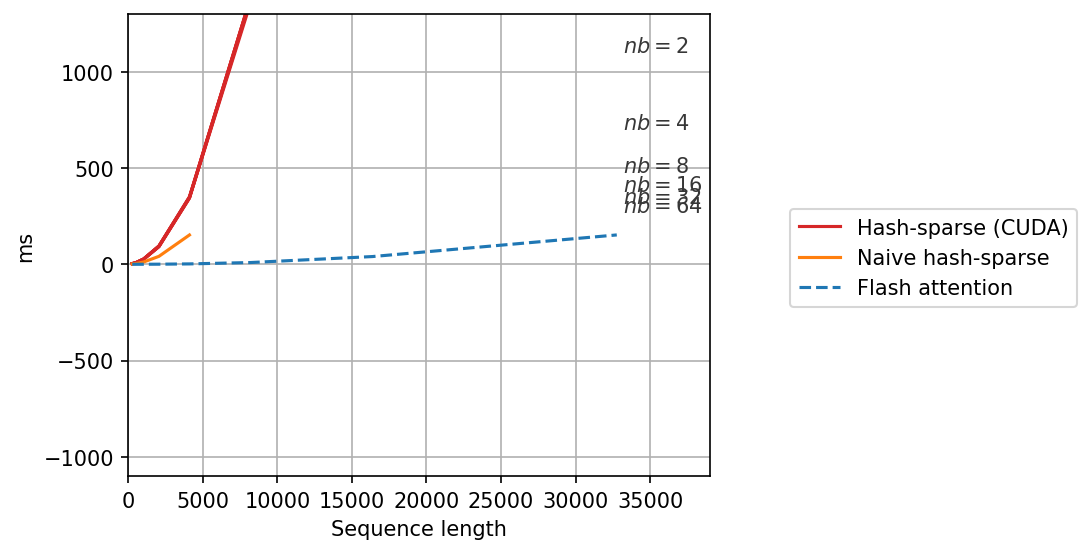

In [8]:

fig, (ax1) = plt.subplots(1, 1, figsize=(5,4), dpi=150)


ax1.grid()

us_q20 = np.array([x[0] for x in us_2])
us_median = np.array([x[1] for x in us_2])
us_q80 = np.array([x[2] for x in us_2])
ax1.plot(N_CTXs, us_median, label="Hash-sparse (CUDA)", color=tableau20[6])
ax1.fill_between(N_CTXs, us_q20, us_q80, alpha=.5, linewidth=0, color=tableau20[7])
ax1.text(33200, 1100, '$nb=2$', color='#373737')

us_q20 = np.array([x[0] for x in us_4])
us_median = np.array([x[1] for x in us_4])
us_q80 = np.array([x[2] for x in us_4])
ax1.plot(N_CTXs, us_median, color=tableau20[6])
ax1.fill_between(N_CTXs, us_q20, us_q80, alpha=.5, linewidth=0, color=tableau20[7])
ax1.text(33200, 700, '$nb=4$', color='#373737')

us_q20 = np.array([x[0] for x in us_8])
us_median = np.array([x[1] for x in us_8])
us_q80 = np.array([x[2] for x in us_8])
ax1.plot(N_CTXs, us_median, color=tableau20[6])
ax1.fill_between(N_CTXs, us_q20, us_q80, alpha=.5, linewidth=0, color=tableau20[7])
ax1.text(33200, 480, '$nb=8$', color='#373737')

us_q20 = np.array([x[0] for x in us_16])
us_median = np.array([x[1] for x in us_16])
us_q80 = np.array([x[2] for x in us_16])
ax1.plot(N_CTXs, us_median, color=tableau20[6])
ax1.fill_between(N_CTXs, us_q20, us_q80, alpha=.5, linewidth=0, color=tableau20[7])
ax1.text(33200, 380, '$nb=16$', color='#373737')

us_q20 = np.array([x[0] for x in us_32])
us_median = np.array([x[1] for x in us_32])
us_q80 = np.array([x[2] for x in us_32])
ax1.plot(N_CTXs, us_median, color=tableau20[6])
ax1.fill_between(N_CTXs, us_q20, us_q80, alpha=.5, linewidth=0, color=tableau20[7])
ax1.text(33200, 320, '$nb=32$', color='#373737')

us_q20 = np.array([x[0] for x in us_64])
us_median = np.array([x[1] for x in us_64])
us_q80 = np.array([x[2] for x in us_64])
ax1.plot(N_CTXs, us_median, color=tableau20[6])
ax1.fill_between(N_CTXs, us_q20, us_q80, alpha=.5, linewidth=0, color=tableau20[7])
ax1.text(33200, 270, '$nb=64$', color='#373737')

them_q20 = np.array([x[0] for x in them])
them_median = np.array([x[1] for x in them])
them_q80 = np.array([x[2] for x in them])

naive_hash_sparse = [1.63515737,   3.83146664,  11.83795198,  41.34331767, 152.38997396]
N_CTXs_ = [258, 512, 1024, 2048, 4096]
ax1.plot(N_CTXs_, naive_hash_sparse, label="Naive hash-sparse", color=tableau20[2])

ax1.plot(N_CTXs, them_median, label="Flash attention", color=tableau20[0], linestyle='--')
ax1.fill_between(N_CTXs, them_q20, them_q80, alpha=.5, linewidth=0, color=tableau20[1])

#ax1.legend(fontsize=10)#loc='center right', fontsize=10)
ax1.set_xlabel('Sequence length')
ax1.set_ylabel('ms')
ax1.set_ylim(ymax=1300)

ax1.set_xlim([0,39000])

ax1.legend(bbox_to_anchor=(1.65, 0.6), ncol=1)

plt.savefig(f"{mode}-hash-sparse-vs-full-flash.pdf", bbox_inches = 'tight')